# Class cuttings

In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt 

from skimage import img_as_ubyte
from skimage.filters import threshold_otsu
from skimage.measure import find_contours,regionprops, label
from skimage.morphology import disk, erosion, dilation
from cuttings import *

#### Read Me :

- List of methods :

In [2]:
def crop_rectangle(im_rect,box,rect):
    W = rect[1][0]
    H = rect[1][1]
    
    Xs = [i[0] for i in box]
    Ys = [i[1] for i in box]
    x1 = min(Xs)
    x2 = max(Xs)
    y1 = min(Ys)
    y2 = max(Ys)
    
    rotated = False
    angle = rect[2]
    
    if angle < -45:
        angle+=90
        rotated = True
        
    size = (x2-x1,y2-y1)
    center = (int((x1+x2)/2), int((y1+y2)/2))
    
    M = cv2.getRotationMatrix2D((size[0]/2, size[1]/2), angle, 1.0)
    
    cropped = cv2.getRectSubPix(im_rect, size, center)    
    cropped = cv2.warpAffine(cropped, M, size)
    
    croppedW = W if not rotated else H 
    croppedH = H if not rotated else W
    
    croppedRotated = cv2.getRectSubPix(cropped, (int(croppedW), int(croppedH)), (size[0]/2, size[1]/2))
    return croppedRotated

In [3]:
root_path = "Cuttings_data/"
fodler_path = "MS-DB-Geo01-1/"

train_tiffs = os.listdir(root_path+fodler_path)

tiff = train_tiffs[491]

FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: 'Cuttings_data/MS-DB-Geo01-1/'

In [2]:
cut = Cuttings(root_path+fodler_path,tiff)

NameError: name 'Cuttings' is not defined

In [3]:
image = cut.load_picture()

NameError: name 'cut' is not defined

In [6]:
mask = cut.assign_mask(image)

In [7]:
dilated = cut.assign_label(mask)

In [8]:
big_samples = cut.big_cuttings(dilated)

In [9]:
def plot_rectangular_samples(image,dilated,big_samples):
    im_rect = (dilated == regionprops(dilated)[im].label).astype(np.uint8)
    contours,_ = cv2.findContours(im_rect, 1, 2)
    rect = cv2.minAreaRect(contours[0])
    if len(contours) >= 2:
        cmax = sorted(contours, key=cv2.contourArea, reverse=True)[0]
        rect = cv2.minAreaRect(cmax)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
       
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(crop_rectangle(im_rect,box,rect),
                cmap='gray')
    ax[0].axis(False)
    ax[1].imshow(crop_rectangle(image*im_rect,box,rect),
                cmap='gray')
    ax[1].axis(False)
    plt.show()

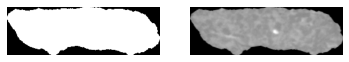

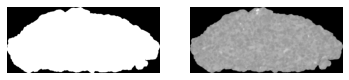

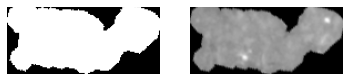

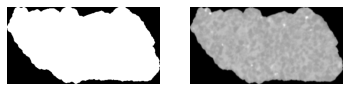

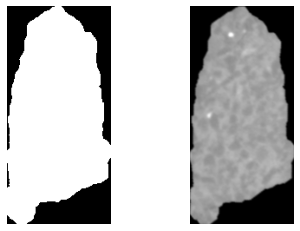

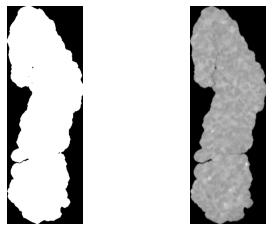

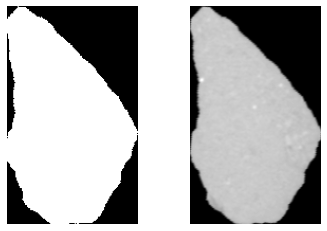

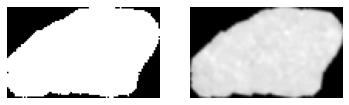

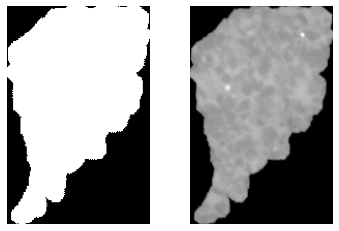

In [10]:
for im in big_samples :
    plot_rectangular_samples(image,dilated,big_samples)

In [11]:
def plot_rectangular_samples_resized(image,dilated,big_samples,WIDTH = 128,HEIGHT = 128):
    im_rect = img_as_ubyte(dilated == regionprops(dilated)[im].label)#.astype(np.uint8)
    contours,_ = cv2.findContours(im_rect, 1, 2)
    rect = cv2.minAreaRect(contours[0])
    if len(contours) >= 2:
        cmax = sorted(contours, key=cv2.contourArea, reverse=True)[0]
        rect = cv2.minAreaRect(cmax)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
        
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(cv2.resize(crop_rectangle(im_rect,box,rect),
                   (WIDTH,HEIGHT), 
                   interpolation=cv2.INTER_CUBIC),
                cmap='gray')
    ax[0].axis(False)
    ax[1].imshow(cv2.resize(crop_rectangle(image*im_rect,box,rect),
                   (WIDTH,HEIGHT), 
                   interpolation=cv2.INTER_CUBIC),
                cmap='gray')
    ax[1].axis(False)
    plt.show()

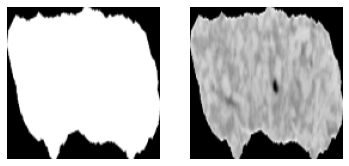

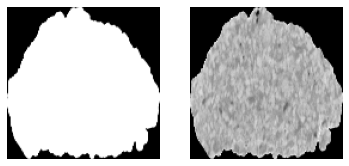

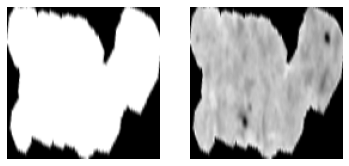

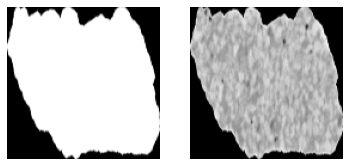

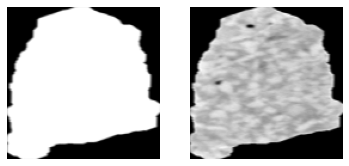

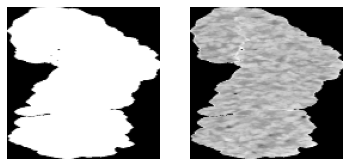

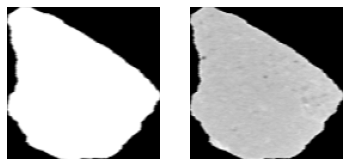

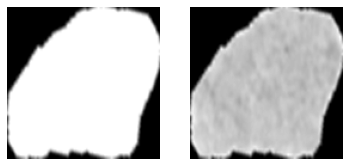

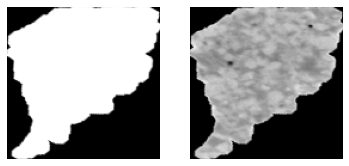

In [13]:
def plot_samples(image,label_image,big_samples):
    minr, minc, maxr, maxc = regionprops(label_image)[im].bbox
        
    fig,ax = plt.subplots(1,2)
        
    ax[0].imshow(image[minr:maxr,minc:maxc]*regionprops(label_image)[im].image,
                cmap=plt.cm.gray,aspect="auto")
    ax[0].axis(False)
    ax[1].imshow(regionprops(label_image)[im].image,
                cmap=plt.cm.gray,aspect="auto")
    ax[1].axis(False)
    plt.show()

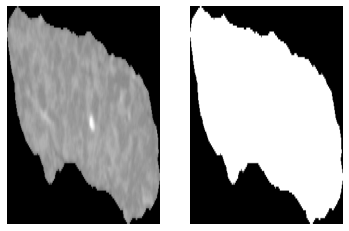

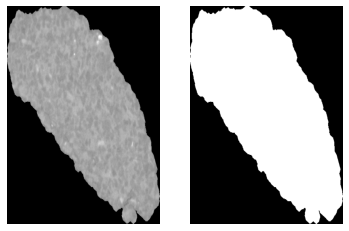

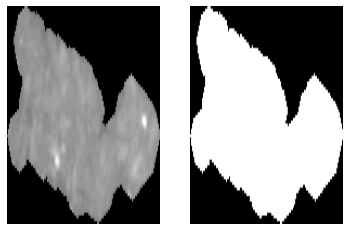

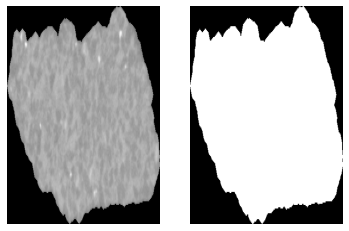

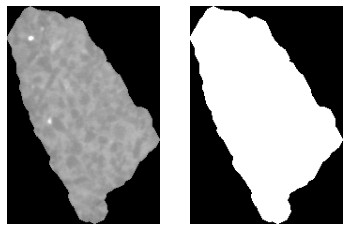

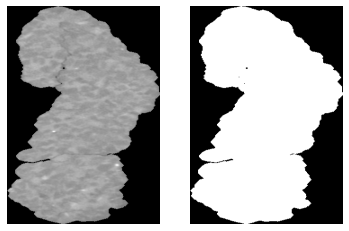

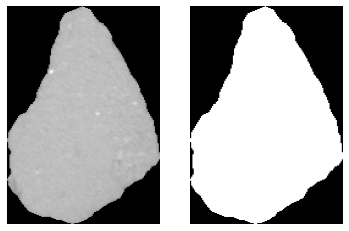

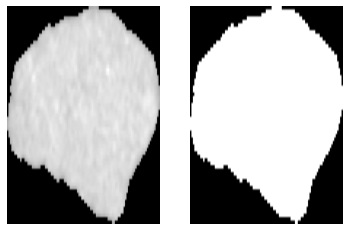

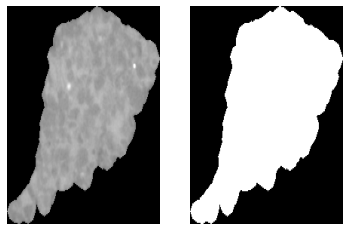

In [14]:
for im in big_samples:
    plot_samples(image,dilated,big_samples)

In [15]:
def plot_samples_resized(image,label_image,big_samples,WIDTH=128,HEIGHT=128): 
    minr, minc, maxr, maxc = regionprops(label_image)[im].bbox
        
    fig,ax = plt.subplots(1,2)
    ax[0].imshow(cv2.resize(image[minr:maxr,minc:maxc]*regionprops(label_image)[im].image,
                   (WIDTH,HEIGHT), 
                   interpolation=cv2.INTER_CUBIC),
                cmap='gray')
    ax[0].axis(False)
    ax[1].imshow(cv2.resize(regionprops(label_image)[im].image.astype(np.uint8),
                   (WIDTH,HEIGHT), 
                   interpolation=cv2.INTER_CUBIC),
                cmap='gray')
    ax[1].axis(False)
    plt.show()

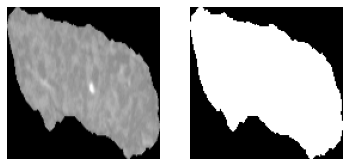

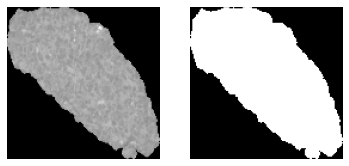

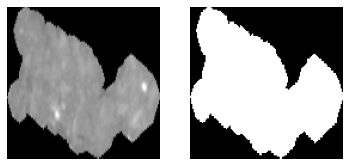

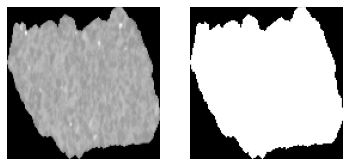

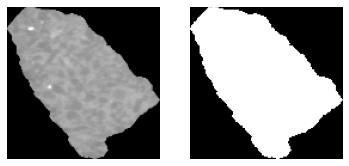

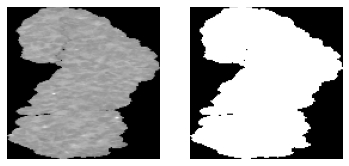

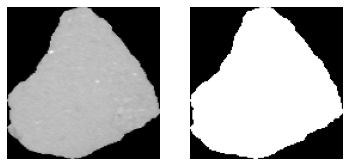

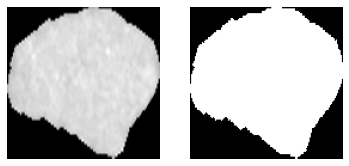

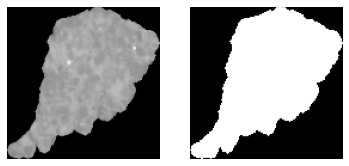

In [16]:
for im in big_samples:
    plot_samples_resized(image,dilated,big_samples)

In [17]:
def pad_image(im_rect_not_pad,desired_size=128):
    old_size = im_rect_not_pad.shape[:2]
    
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im_rect_not_pad_resized = cv2.resize(im_rect_not_pad, (new_size[1], new_size[0]),interpolation=cv2.INTER_CUBIC)
    
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    
    color = 0
    
    im_rect_pad = cv2.copyMakeBorder(im_rect_not_pad_resized, top, bottom, left, right, cv2.BORDER_CONSTANT,
    value=color)
    return im_rect_pad

In [18]:
def plot_samples_padded(image,label_image,big_samples):
    minr, minc, maxr, maxc = regionprops(label_image)[im].bbox
        
    fig,ax = plt.subplots(1,2)
        
    ax[0].imshow(pad_image(image[minr:maxr,minc:maxc]*regionprops(label_image)[im].image),
                cmap=plt.cm.gray,aspect="auto")
    ax[0].axis(False)
    ax[1].imshow(pad_image(regionprops(label_image)[im].image.astype(np.uint8)),
                cmap=plt.cm.gray,aspect="auto")
    ax[1].axis(False)
    plt.show()

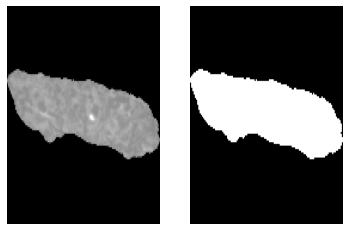

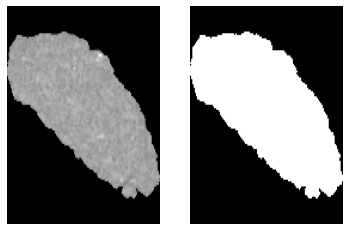

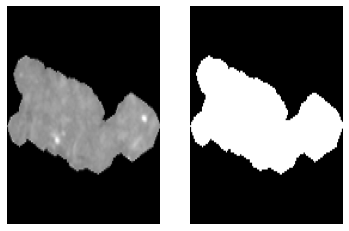

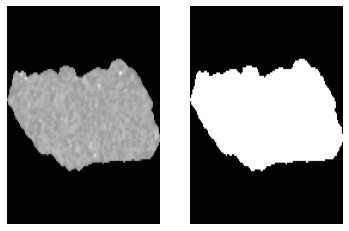

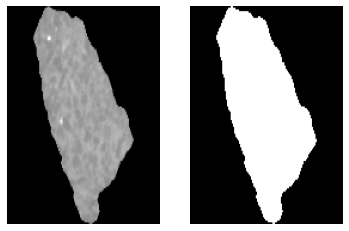

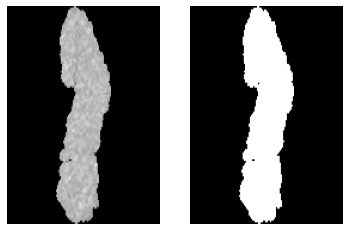

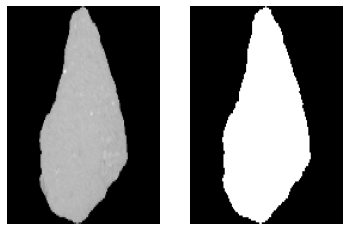

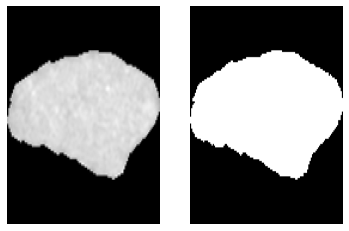

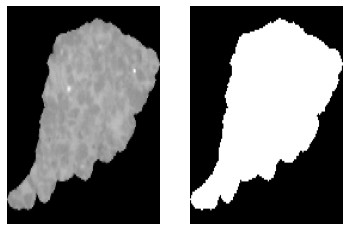

In [19]:
for im in big_samples:
    plot_samples_padded(image,dilated,big_samples)

In [20]:
def plot_rectangular_samples_padded(image,dilated,big_samples):
    im_rect = img_as_ubyte(dilated == regionprops(dilated)[im].label)#.astype(np.uint8)
    contours,_ = cv2.findContours(im_rect, 1, 2)
    rect = cv2.minAreaRect(contours[0])
    if len(contours) >= 2:
        cmax = sorted(contours, key=cv2.contourArea, reverse=True)[0]
        rect = cv2.minAreaRect(cmax)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(pad_image(crop_rectangle(im_rect,box,rect)),
                cmap='gray')
    ax[0].axis(False)

    ax[1].imshow(pad_image(crop_rectangle(image*im_rect,box,rect)),
                cmap='gray')
    ax[1].axis(False)

    plt.show()

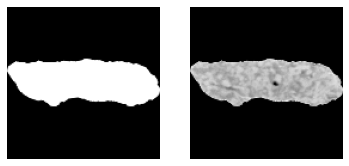

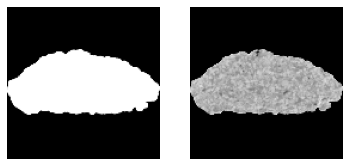

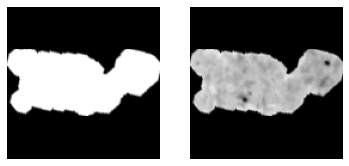

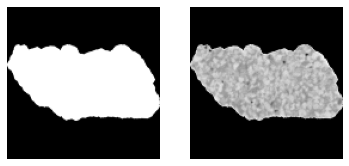

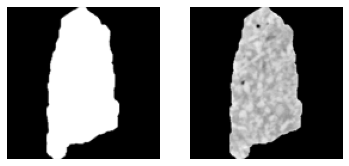

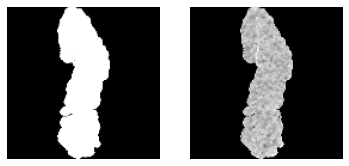

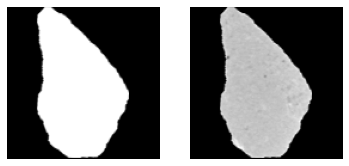

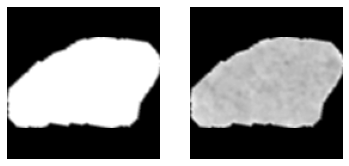

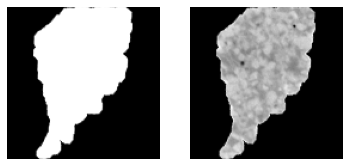

In [21]:
for im in big_samples:
    plot_rectangular_samples_padded(image,dilated,big_samples)

#### Figures Report

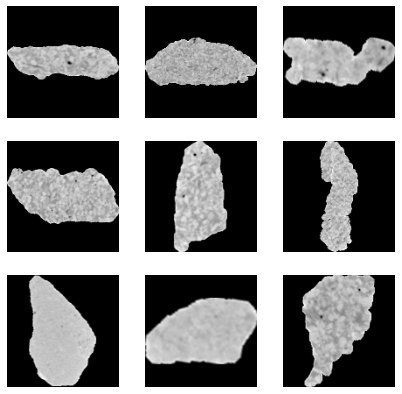

In [22]:
fig, axs = plt.subplots(3,3,figsize=(7,7))

axs = axs.ravel()

for i,im in enumerate(big_samples):
    im_rect = img_as_ubyte(dilated == regionprops(dilated)[im].label)#.astype(np.uint8)
    contours,_ = cv2.findContours(im_rect, 1, 2)
    rect = cv2.minAreaRect(contours[0])
    if len(contours) >= 2:
        cmax = sorted(contours, key=cv2.contourArea, reverse=True)[0]
        rect = cv2.minAreaRect(cmax)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    axs[i].imshow(pad_image(crop_rectangle(image*im_rect,box,rect)),
                cmap='gray')
    axs[i].axis(False)
plt.savefig('experimental_set_up_padded.png',bbox_inches='tight',dpi=600)

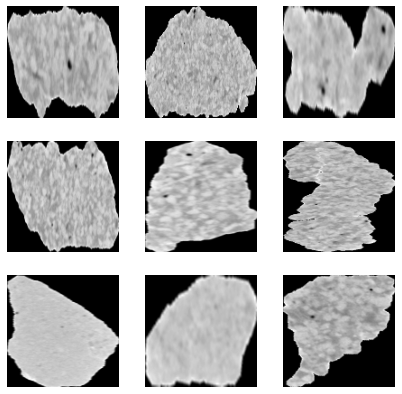

In [23]:
fig, axs = plt.subplots(3,3,figsize=(7,7))

axs = axs.ravel()

for i,im in enumerate(big_samples):
    im_rect = img_as_ubyte(dilated == regionprops(dilated)[im].label)#.astype(np.uint8)
    contours,_ = cv2.findContours(im_rect, 1, 2)
    rect = cv2.minAreaRect(contours[0])
    if len(contours) >= 2:
        cmax = sorted(contours, key=cv2.contourArea, reverse=True)[0]
        rect = cv2.minAreaRect(cmax)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    WIDTH = 224
    HEIGHT = 224
    axs[i].imshow(cv2.resize(crop_rectangle(image*im_rect,box,rect),
                   (WIDTH,HEIGHT), 
                   interpolation=cv2.INTER_CUBIC),
                cmap='gray')
    axs[i].axis(False)
plt.savefig('experimental_set_up_not_padded.png',bbox_inches='tight',dpi=600)   

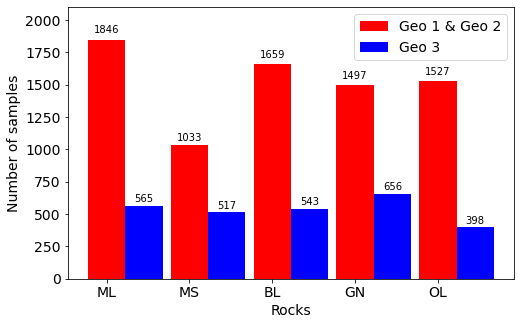

In [24]:
# Train Test Split
labels = ['ML','MS','BL','GN','OL']

train = [1846,1033,1659,1497,1527]
test = [565,517,543,656,398]

ind = np.arange(len(labels))

bar_width = 0.45

fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(ind, train, bar_width, color='r',
                label='Geo 1 & Geo 2')
rects2 = ax.bar(ind+bar_width, test, bar_width, color='b',
                label='Geo 3')
ax.set_xlabel('Rocks',fontsize=14)
ax.set_ylabel('Number of samples',fontsize=14)
ax.set_xticks(ind)
ax.set_xticklabels(labels,fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.ylim(0,2100)
for rect, tr in zip(rects1, train):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height*1.02, '{}'.format(tr), ha='center', va='bottom')
for rect, te in zip(rects2, test):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height*1.02, '{}'.format(te), ha='center', va='bottom')

plt.savefig('train_test_validation.png',dpi=600,bbox_inches='tight')